In [1]:
from scipy.stats import norm
from scipy.stats import gaussian_kde
from scipy.stats import multivariate_normal as mn
from numpy.random import multivariate_normal
import pandas as pd
import numpy as np
from numpy.polynomial.legendre import Legendre as le
import seaborn as sns
from plotnine import *
from cflDensity import *
import random
from sklearn.datasets import make_spd_matrix
from multiprocessing import Pool

# 2-D Examples

## Subspace

### Generating Data

In [16]:
ostats = pd.DataFrame({"mean": [-.3, 0, .6],
                      "sd": [.1, .05, .2],
                      "size": [200, 100, 30]})

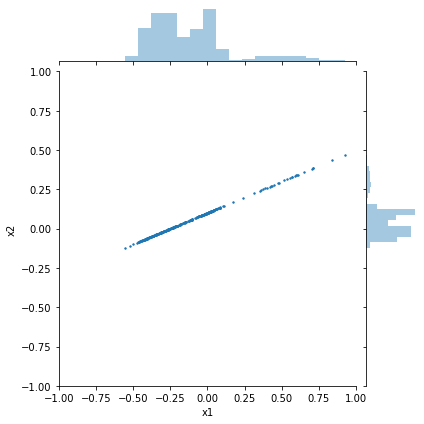

In [34]:
fx = np.vectorize(lambda x: .4 * x + .1)

rands = list()
for i,stat in ostats.iterrows():
    rands.extend(norm.rvs(stat["mean"], stat["sd"], stat["size"].astype(int), random_state=i))

mData = pd.DataFrame({'x1': rands,
                     'x2': fx(rands)})
ind = (-1 <= mData) & (mData <= 1)
mData = mData[ind.apply(all, 1)]

#pl = ggplot(aes('x1', 'x2'), mData) + geom_point(alpha = .1)
#pl + stat_density(geom = 'raster', aes = aes(fill = '..density..'), contour = False)
ap = sns.jointplot(x=mData['x1'], y=mData['x2'], kind='scatter', s=2, xlim=(-1,1), ylim=(-1,1))

In [31]:
pData = []
for x1 in np.linspace(-1, 1, 200):
    for x2 in np.linspace(-1, 1, 200):
        pData.append(pd.DataFrame({'x1':[x1], 'x2':[x2]}))
pData = pd.concat(pData)
grid = np.asarray(pData)

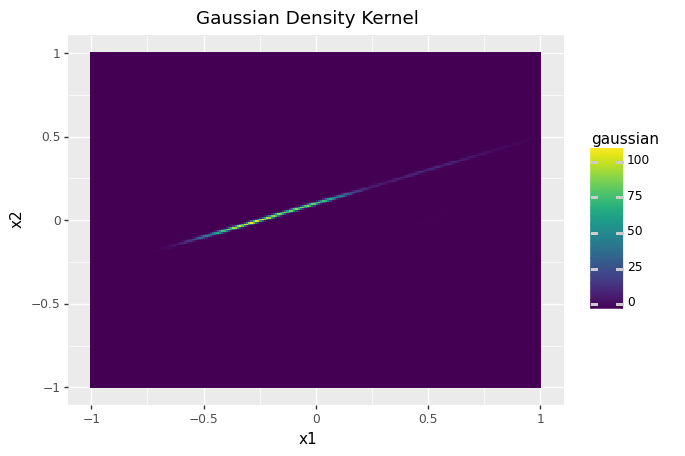

<ggplot: (8762769400840)>

In [33]:
gData = mData.append(pd.DataFrame({'x1': .5,
                     'x2': 0}, index=['extra']))
kernel = gaussian_kde(np.transpose(gData.values))
pData['gaussian'] = kernel(np.transpose(grid))
(ggplot(aes('x1', 'x2', fill = 'gaussian'), pData) + geom_tile() +
 ggtitle('Gaussian Density Kernel'))

In [5]:
x = np.asarray(mData)
dist = euclidean_distances(x, x)
r = getBestRad(dist = dist, n = 1)

In [6]:
estimate = getftd2(grid, x, r)
estimate[estimate<0] = 0
pData['f'] = estimate
pl = (ggplot(aes('x1', 'x2', fill = 'f'), pData) + geom_tile())

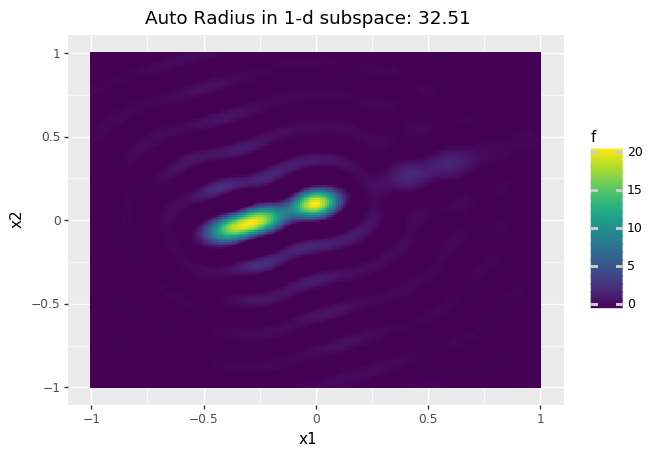

<ggplot: (-9223363297586026720)>

In [7]:
pl + ggtitle('Auto Radius in 1-d subspace: ' + str(float(("%0.2f"%r))))

## Full Space

In [13]:
mstats = pd.DataFrame({"mean": [-.3, 0, .6, .5, -.1],
                      "sd": [.1, .05, .2, .1, .1],
                      "size": [200, 100, 60, 100, 120]})

In [14]:
rands2d = list()
trueDens = np.zeros(len(grid))
np.random.seed(3)
random.seed(3)
for i,stat in mstats.iterrows():
    mean = np.array([random.uniform(-.8, .8), random.uniform(-.8, .8)])
    var = make_spd_matrix(2) * stat["sd"] / 3
    rands2d.extend(multivariate_normal(mean, var, stat["size"].astype(int)))
    trueDens += mn.pdf(grid, mean, var) * stat["size"]
rands2d = np.stack(rands2d)
mpData = pd.DataFrame(grid, columns={'x1', 'x2'})
mpData['true'] = trueDens / sum(mstats['size'])
kernel = gaussian_kde(np.transpose(rands2d))
mpData['gaussian'] = kernel(np.transpose(grid))

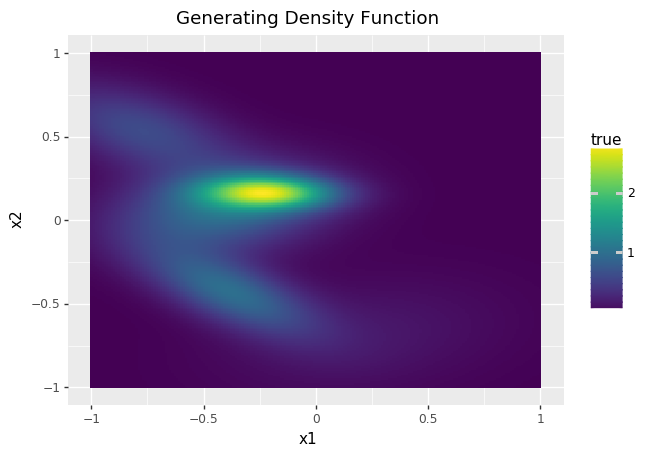

<ggplot: (-9223363297722836080)>

In [10]:
(ggplot(aes('x1', 'x2', fill = 'true'), mpData) + geom_tile() +
 ggtitle('Generating Density Function'))

/homes/olymp/dominik.otto/Envs/noteEnv/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


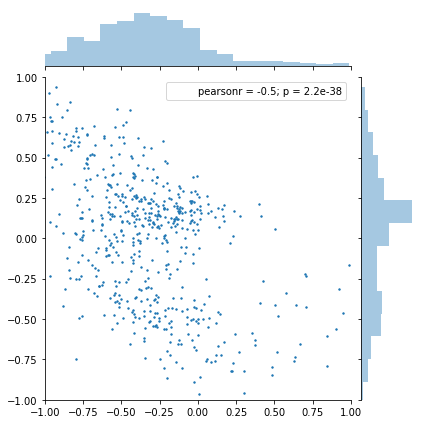

In [11]:
sns.jointplot(x=rands2d[:,0], y=rands2d[:,1], kind='scatter', s=2, xlim=(-1,1), ylim=(-1,1))

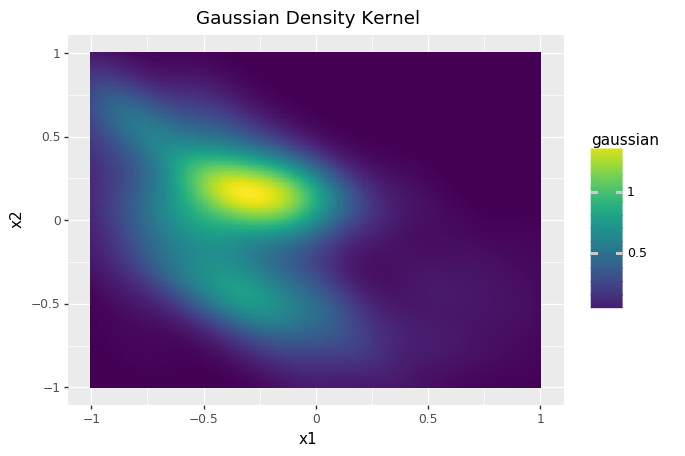

<ggplot: (-9223363297722868385)>

In [12]:
(ggplot(aes('x1', 'x2', fill = 'gaussian'), mpData) + geom_tile() +
 ggtitle('Gaussian Density Kernel'))

In [13]:
dist = euclidean_distances(rands2d, rands2d)
r = getBestRad(dist = dist, n = rands2d.shape[1])

In [14]:
estimate = getftd2(grid, rands2d, r)
estimate[estimate<0] = 0
mpData['f'] = estimate
m2pl = (ggplot(aes('x1', 'x2', fill = 'f'), mpData) + geom_tile())

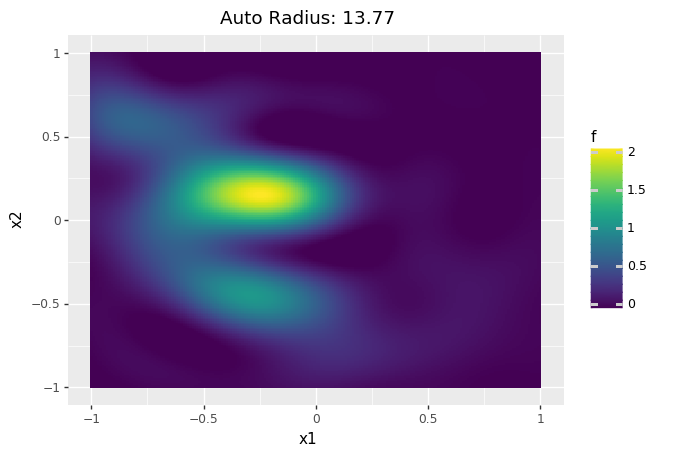

<ggplot: (-9223363297726820811)>

In [15]:
m2pl + ggtitle('Auto Radius: ' + str(float(("%0.2f"%r))))

In [16]:
def err_direct(dat):
    r, xses, x, trueDens = dat
    estimate = getftd2(xs=grid, x=x, r=r)
    estimate[estimate<0] = 0
    diff = (estimate - trueDens) / len(trueDens)
    return np.dot(diff, diff)

frequencies = range(100)
p = Pool()
doData = [(r, grid, rands2d, mpData['true']) for r in frequencies]
vals = p.map_async(err_direct, doData)
errData = pd.DataFrame({'error-sq':vals.get(),
                       'max-freq':list(frequencies)})

In [17]:
maxIndex = errData['error-sq'].idxmin()
dots = pd.DataFrame({'freq':[errData.loc[maxIndex, 'max-freq']],
                    'err':[errData.loc[maxIndex, 'error-sq']],
                    'points':['best found with known density']})
cfDiff = (mpData['f'] - mpData['true']) / len(mData)
cfErr = np.dot(cfDiff, cfDiff)
dots.loc[2] = [cfErr, r, 'found by cross validation']
gausDiff = (mpData['gaussian'] - mpData['true']) / len(mData)
gausErr = np.dot(gausDiff, gausDiff)

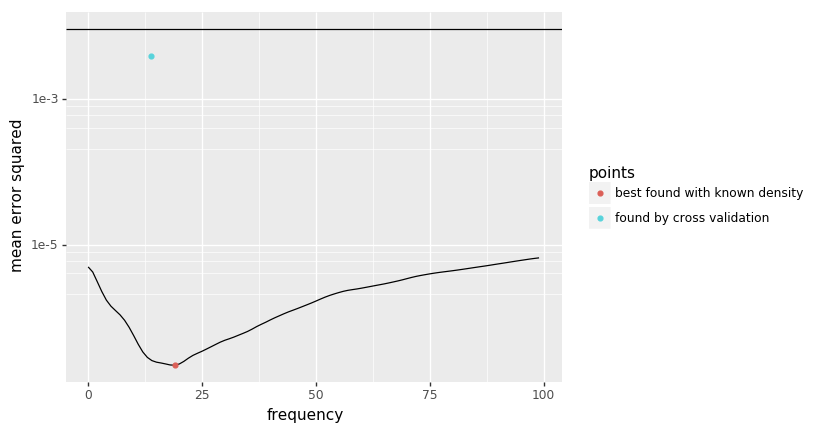

<ggplot: (8739125372536)>

In [18]:
(ggplot(aes('max-freq', 'error-sq'), errData) + geom_line() +
 ylab('mean error squared') + xlab('frequency') + scale_y_log10() +
 geom_point(aes('freq', 'err', color='points'), dots) +
 geom_hline(yintercept = gausErr))

## Different Scales

In [19]:
smpData = mpData
smpData['x1'] = smpData['x1']*100 # change scale
kernel = gaussian_kde(np.transpose(smpData[['x1', 'x2']]))
mpData['gaussian'] = kernel(np.transpose(grid))

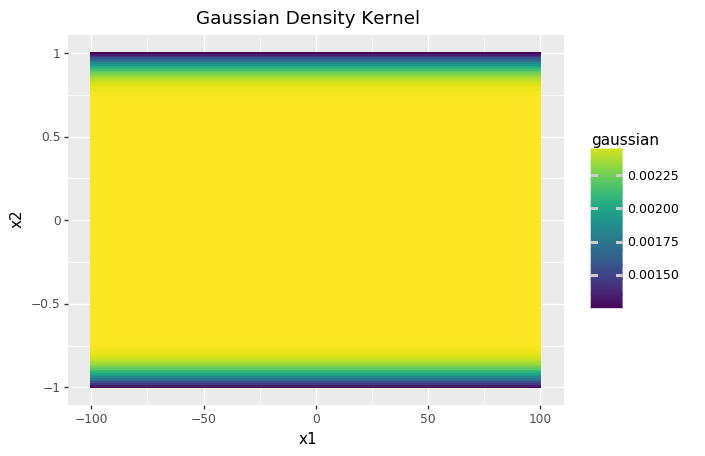

<ggplot: (-9223363297724355317)>

In [20]:
(ggplot(aes('x1', 'x2', fill = 'gaussian'), mpData) + geom_tile() +
 ggtitle('Gaussian Density Kernel'))

In [ ]:
dist = euclidean_distances(smpData[['x1', 'x2']], smpData[['x1', 'x2']])
r = getBestRad(dist = dist, n = 2)

In [ ]:
estimate = getftd2(grid, smpData[['x1', 'x2']], r)
estimate[estimate<0] = 0
smpData['f'] = estimate
m2pl = (ggplot(aes('x1', 'x2', fill = 'f'), mpData) + geom_tile())

In [ ]:
m2pl + ggtitle('Auto Radius: ' + str(float(("%0.2f"%r))))

In [ ]:
def err_direct(dat):
    r, xses, x, trueDens = dat
    estimate = getftd2(xs=grid, x=x, r=r)
    estimate[estimate<0] = 0
    diff = (estimate - trueDens) / len(trueDens)
    return np.dot(diff, diff)

frequencies = range(100)
p = Pool()
doData = [(r, grid, rands2d, mpData['true']) for r in frequencies]
vals = p.map_async(err_direct, doData)
errData = pd.DataFrame({'error-sq':vals.get(),
                       'max-freq':list(frequencies)})

In [ ]:
maxIndex = errData['error-sq'].idxmin()
dots = pd.DataFrame({'freq':[errData.loc[maxIndex, 'max-freq']],
                    'err':[errData.loc[maxIndex, 'error-sq']],
                    'points':['best found with known density']})
cfDiff = (mpData['f'] - mpData['true']) / len(mData)
cfErr = np.dot(cfDiff, cfDiff)
dots.loc[2] = [cfErr, r, 'found by cross validation']
gausDiff = (mpData['gaussian'] - mpData['true']) / len(mData)
gausErr = np.dot(gausDiff, gausDiff)

In [ ]:
(ggplot(aes('max-freq', 'error-sq'), errData) + geom_line() +
 ylab('mean error squared') + xlab('frequency') + scale_y_log10() +
 geom_point(aes('freq', 'err', color='points'), dots) +
 geom_hline(yintercept = gausErr))

# 500-D Example

In [ ]:
n = 500
trainData = list()
testData = list()
mvStats = []
np.random.seed(3)
random.seed(3)
for i,stat in mstats.iterrows():
    mean = np.array([random.uniform(-.8, .8) for i in range(n)])
    var = make_spd_matrix(n) * stat["sd"] / 3
    size = (stat["size"] / 10).astype(int)
    trainData.extend(multivariate_normal(mean, var, size))
    testData.extend(multivariate_normal(mean, var, size))
    mvStats.append({'mean':mean, 'var':var, 'size':size})
trainData = np.stack(trainData)
testData = np.stack(testData)
trueDensMV = np.zeros(len(testData))
for stat in mvStats:
    trueDensMV += mn.pdf(testData, stat['mean'], stat['var'])

In [ ]:
dist = euclidean_distances(trainData, trainData)
r = getBestRad(dist = dist, n = trainData.shape[1])

In [ ]:
r

In [ ]:
import importlib
import cflDensity
importlib.reload(cflDensity)
from cflDensity import *
radii = np.linspace(1, 1e10, 100)
def mll(r): return np.real(ll(r, dist = dist, n = 500, log=True))
p = Pool()
vals = p.map_async(mll, radii)
result = pd.DataFrame({'radius':radii,
                       'likelyhood':vals.get()})
p.close()

In [ ]:
maxIndex = result['likelyhood'].idxmax()
bestRad = result.loc[maxIndex, 'radius']
(ggplot(aes('radius', 'likelyhood'), result) + geom_line() + geom_vline(xintercept = bestRad))

In [ ]:
def err_direct(dat):
    r, xses, x = dat
    values = getftd2(xses, x, r, log=True)
    diff = (values - np.log(trueDensMV)) / len(trueDensMV)
    return np.dot(diff, diff)
def dkld(dat):
    r, testData, trainData, genF = dat
    values = getftd2(testData, trainData, r, log=True)
    dist = np.sum(np.log(genF) - values)
    return np.real(dist)

p = Pool()
doData = [(r, testData, trainData, trueDensMV) for r in radii]
vals = p.map_async(dkld, doData)
lkld = vals.get()
errData = pd.DataFrame({'log KLD':lkld,
                       'max-freq':list(radii)})

In [ ]:
(ggplot(aes('max-freq', 'log KLD'), errData) + geom_line())